In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
import tensorflow_addons as tfa

from tensorflow.keras.preprocessing import image_dataset_from_directory
#tf.config.experimental.set_memory_growth(tf.config.list_physical_devices('GPU')[0], True)
# Load the TensorBoard notebook extension
%load_ext tensorboard

In [2]:
BATCH_SIZE = 32
IMG_SIZE = (224, 224)

train_dataset  = tf.keras.preprocessing.image_dataset_from_directory('./aptos/preprocessed/train',
                                            shuffle = True,
                                            batch_size = BATCH_SIZE,
                                            image_size = IMG_SIZE,
                                            validation_split = 0.15, subset = 'training', seed = 1234)

Found 3662 files belonging to 5 classes.
Using 3113 files for training.


In [3]:
validation_dataset = train_dataset  = tf.keras.preprocessing.image_dataset_from_directory('./aptos/preprocessed/train',
                                            shuffle = True,
                                            batch_size = BATCH_SIZE,
                                            image_size = IMG_SIZE,
                                            validation_split = 0.15, subset = 'validation', seed = 1234)

Found 3662 files belonging to 5 classes.
Using 549 files for validation.


In [4]:
test_dataset = image_dataset_from_directory('./aptos/preprocessed/test',
                                                 shuffle = True,
                                                 batch_size = BATCH_SIZE,
                                                 image_size = IMG_SIZE)

Found 103 files belonging to 5 classes.


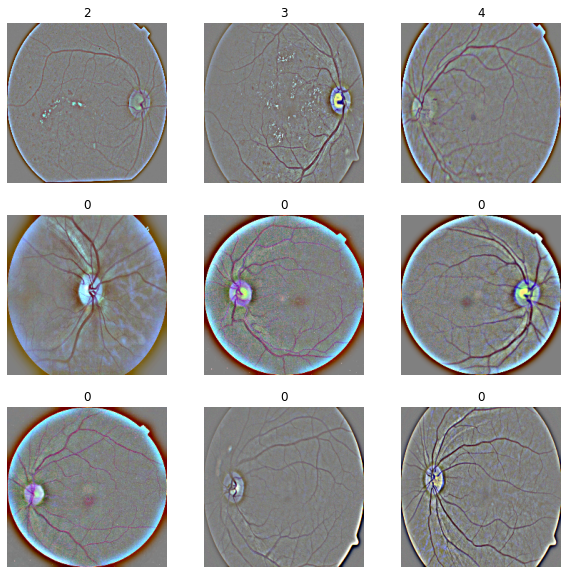

In [5]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [6]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 18
Number of test batches: 4


In [7]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size = AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size = AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size = AUTOTUNE)

In [8]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
    tf.keras.layers.experimental.preprocessing.RandomFlip('vertical'),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.5)
])

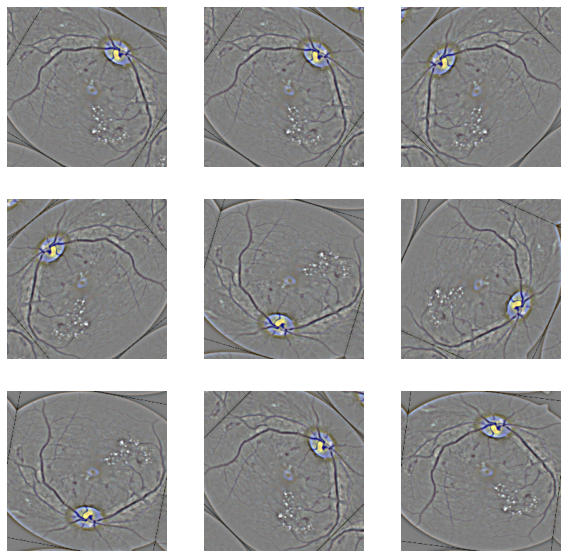

In [9]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

In [10]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [11]:
rescale = tf.keras.layers.experimental.preprocessing.Rescaling(1./255, offset = -1)

In [12]:
IMG_SHAPE = IMG_SIZE + (3,)

base_model = tf.keras.applications.MobileNetV2(input_shape = IMG_SHAPE,
                                              include_top = False,
                                              weights = 'imagenet')

In [13]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 7, 7, 1280)


In [14]:
base_model.trainable = False

In [15]:
base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
_______________________________________________________________________________

In [16]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


In [17]:
prediction_layer = tf.keras.layers.Dense(5)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 5)


In [18]:
inputs = tf.keras.Input(shape = (224, 224, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training = False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [23]:
base_learning_rate = 0.0001
model.compile(optimizer = tf.keras.optimizers.Adam(lr = base_learning_rate),
             loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True),
             metrics = ['accuracy', tfa.metrics.MultiLabelConfusionMatrix(num_classes = 5),
                       tfa.metrics.CohenKappa(num_classes = 5, sparse_labels = True)])

In [24]:
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 224, 224, 3)       0         
_________________________________________________________________
tf_op_layer_RealDiv (TensorF [(None, 224, 224, 3)]     0         
_________________________________________________________________
tf_op_layer_Sub (TensorFlowO [(None, 224, 224, 3)]     0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)             

In [25]:
len(model.trainable_variables)

2

In [26]:
initial_epochs = 5

loss, accuracy, confusion, kappa = model.evaluate(validation_dataset)

18/18 [==============================] - 7s 384ms/step - loss: 2.4105 - accuracy: 0.2805 - Multilabel_confusion_matrix: 201.9000 - cohen_kappa: 0.0030


In [29]:
print("initial loss: {:.2f}".format(loss))
print("initial accuracy: {:.2f}".format(accuracy))

initial loss: 2.41
initial accuracy: 0.28


In [30]:
# Clear any logs from previous runs
import datetime
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [31]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset,
                    callbacks=[tensorboard_callback])

Epoch 1/5
 1/18 [>.............................] - ETA: 0s - loss: 2.4096 - accuracy: 0.2500 - Multilabel_confusion_matrix: 11.9500 - cohen_kappa: 0.0065WARNING:tensorflow:From /home/himangshu/anaconda3/envs/tf_ljmu/lib/python3.8/site-packages/tensorflow/python/ops/summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
18/18 [==============================] - 18s 1s/step - loss: 2.1502 - accuracy: 0.2514 - Multilabel_confusion_matrix: 198.1000 - cohen_kappa: 0.0039 - val_loss: 1.6626 - val_accuracy: 0.3115 - val_Multilabel_confusion_matrix: 193.7000 - val_cohen_kappa: 0.0399
Epoch 2/5
18/18 [==============================] - 18s 992ms/step - loss: 1.5524 - accuracy: 0.3953 - Multilabel_confusion_matrix: 196.9000 - cohen_kappa: 0.1038 - val_loss: 1.2879 - val_accuracy: 0.4080 - val_Multilabel_confusion_matrix: 193.6000 - val_cohen_kappa: 0.1330
Epoch 

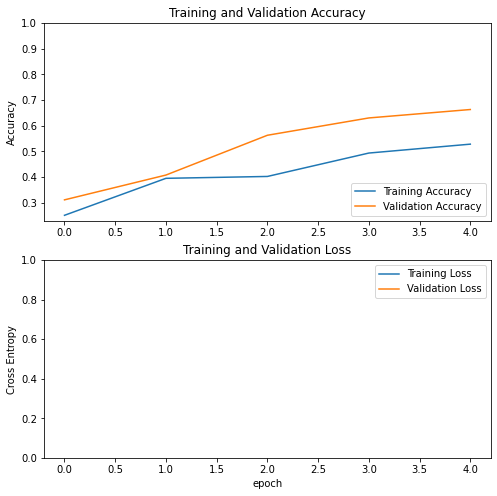

In [32]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [33]:
base_model.trainable = True

In [34]:
print("Number of layers in the base model: ", len(base_model.layers))

fine_tune_at = 100

for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

Number of layers in the base model:  155


In [35]:
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=5, restore_best_weights=True, verbose=1)
rlrop = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience=3, factor=0.5, min_lr=1e-6, verbose=1)
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath='./mobilenet_ckp', save_weights_only=True,
                    monitor='val_accuracy', mode='max', save_best_only=True)

callback_list = [es, rlrop, model_checkpoint, tensorboard_callback]

In [36]:
model.compile(loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True),
             optimizer = tf.keras.optimizers.Adam(lr = base_learning_rate / 2),
             metrics = ['accuracy', tfa.metrics.MultiLabelConfusionMatrix(num_classes = 5),
                       tfa.metrics.CohenKappa(num_classes = 5, sparse_labels = True)])

In [37]:
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 224, 224, 3)       0         
_________________________________________________________________
tf_op_layer_RealDiv (TensorF [(None, 224, 224, 3)]     0         
_________________________________________________________________
tf_op_layer_Sub (TensorFlowO [(None, 224, 224, 3)]     0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)             

In [38]:
len(model.trainable_variables)

58

In [39]:
fine_tune_epochs = 50
total_epochs = initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                        epochs = total_epochs,
                        initial_epoch = history.epoch[-1],
                        validation_data = validation_dataset,
                        callbacks = callback_list)

Epoch 5/55
18/18 [==============================] - 22s 1s/step - loss: 0.9553 - accuracy: 0.6612 - Multilabel_confusion_matrix: 230.6000 - cohen_kappa: 0.4657 - val_loss: 0.8138 - val_accuracy: 0.6885 - val_Multilabel_confusion_matrix: 246.7000 - val_cohen_kappa: 0.5162
Epoch 6/55
18/18 [==============================] - 22s 1s/step - loss: 0.7878 - accuracy: 0.7013 - Multilabel_confusion_matrix: 237.8000 - cohen_kappa: 0.5370 - val_loss: 0.7151 - val_accuracy: 0.7322 - val_Multilabel_confusion_matrix: 237.5000 - val_cohen_kappa: 0.5802
Epoch 7/55
18/18 [==============================] - 22s 1s/step - loss: 0.7008 - accuracy: 0.7377 - Multilabel_confusion_matrix: 238.5500 - cohen_kappa: 0.5904 - val_loss: 0.6255 - val_accuracy: 0.7741 - val_Multilabel_confusion_matrix: 229.1500 - val_cohen_kappa: 0.6541
Epoch 8/55
18/18 [==============================] - 22s 1s/step - loss: 0.7524 - accuracy: 0.7322 - Multilabel_confusion_matrix: 239.0500 - cohen_kappa: 0.5904 - val_loss: 0.6620 - val

18/18 [==============================] - 37s 2s/step - loss: 0.3384 - accuracy: 0.8707 - Multilabel_confusion_matrix: 243.5000 - cohen_kappa: 0.8049 - val_loss: 0.3317 - val_accuracy: 0.8670 - val_Multilabel_confusion_matrix: 246.2500 - val_cohen_kappa: 0.7983
Epoch 34/55
18/18 [==============================] - 37s 2s/step - loss: 0.3301 - accuracy: 0.8689 - Multilabel_confusion_matrix: 245.0000 - cohen_kappa: 0.8025 - val_loss: 0.3326 - val_accuracy: 0.8743 - val_Multilabel_confusion_matrix: 242.9500 - val_cohen_kappa: 0.8105
Epoch 35/55
18/18 [==============================] - 37s 2s/step - loss: 0.3194 - accuracy: 0.8761 - Multilabel_confusion_matrix: 241.8500 - cohen_kappa: 0.8153 - val_loss: 0.4224 - val_accuracy: 0.8306 - val_Multilabel_confusion_matrix: 247.0000 - val_cohen_kappa: 0.7397
Epoch 36/55
18/18 [==============================] - ETA: 0s - loss: 0.3356 - accuracy: 0.8652 - Multilabel_confusion_matrix: 243.8500 - cohen_kappa: 0.7983
Epoch 00036: ReduceLROnPlateau reduc

In [43]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

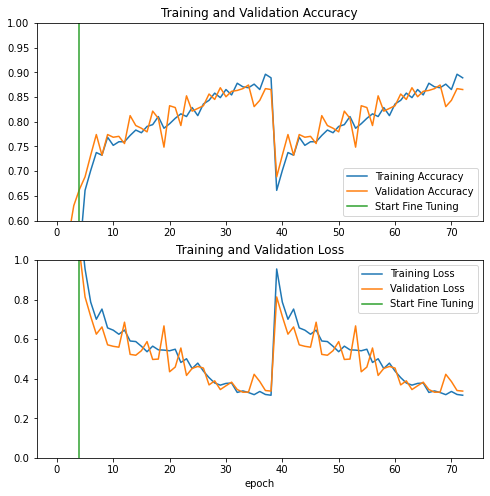

In [44]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.6, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [46]:
loss, accuracy, confusion, kappa = model.evaluate(test_dataset)
print('Test accuracy: ', accuracy)

4/4 [==============================] - 1s 206ms/step - loss: 1.8316 - accuracy: 0.3592 - Multilabel_confusion_matrix: 45.7500 - cohen_kappa: 0.1612
Test accuracy:  0.35922330617904663


In [47]:
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()
predictions = tf.nn.softmax(predictions)
predictions = tf.reshape(predictions, [32, 5])
predictions = tf.argmax(predictions, 1)

Predictions:
 [2 1 2 0 0 1 2 0 0 1 0 2 1 1 1 2 2 0 2 1 4 2 2 0 1 2 4 0 0 2 2 2]
Labels:
 [4 2 2 0 0 0 3 1 2 2 0 3 1 0 0 4 4 3 3 0 3 3 2 0 0 3 2 2 0 2 3 4]


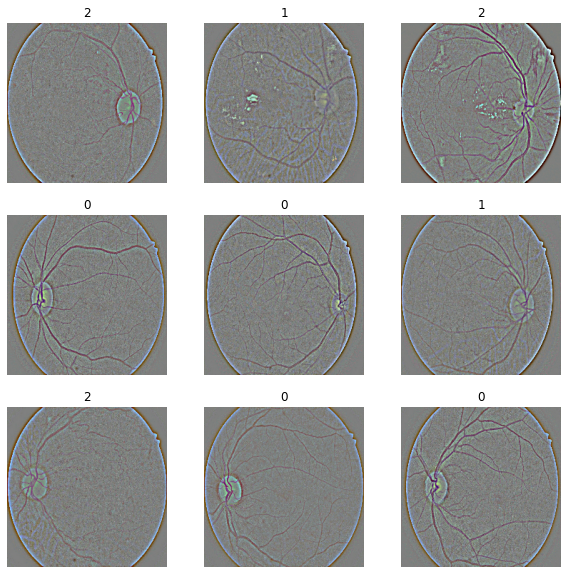

In [48]:
print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")

In [49]:
%tensorboard --logdir logs/fit

Reusing TensorBoard on port 6007 (pid 6960), started 8:28:06 ago. (Use '!kill 6960' to kill it.)